import everything

In [1]:
import os
import glob
import numpy as np
from platform import system as OS
import pandas as pd
import scipy.stats
import math
import datetime
from copy import deepcopy
import matplotlib.cm as cm
import warnings
import types
warnings.filterwarnings("ignore")
import sys, time
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import mlab
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import matplotlib.backends.backend_pdf
from sklearn.decomposition import KernelPCA
import mpl_toolkits.axes_grid1.inset_locator as inset
from matplotlib.ticker import FormatStrFormatter



if "__file__" not in dir():
    %matplotlib inline
    %config InlineBackend.close_figures = False
    
    ThisNoteBookPath=os.path.dirname(os.path.realpath("__file__"))
    CommonNoteBookesPath=os.path.join(os.path.split(ThisNoteBookPath)[0],"load_preprocess_rat")
    CWD=os.getcwd()
    os.chdir(CommonNoteBookesPath)
    %run UtilityTools.ipynb
    %run Animal_Tags.ipynb
    %run loadRat_documentation.ipynb
    %run plotRat_documentation_1_GeneralBehavior.ipynb
    %run plotRat_documentation_3_KinematicsInvestigation.ipynb
    %run RunBatchRat_3_CompareGroups.ipynb
    %run BatchRatBehavior.ipynb
    %run ../BehavioralPaper/ImmTrd.ipynb
    os.chdir(CWD)
    # PARAMETERS (used if the pickles don't exist)
    param={
        "goalTime":7,#needed for pavel data only
        "treadmillRange":[0,90],#pavel error conversion "treadmillRange":[0,80]
        "maxTrialDuration":15,
        "interTrialDuration":10,#None pavel
        "endTrial_frontPos":30,
        "endTrial_backPos":55, 
        "endTrial_minTimeSec":4,
        "cameraSamplingRate":25, #needed for new setup    

        "sigmaSmoothPosition":0.1,#0.33, 0.18 pavel
        "sigmaSmoothSpeed":0.3,#0.3, 0.5 pavel
        "nbJumpMax":100,#200 pavel
        "binSize":0.25,
        #parameters used to preprocess (will override the default parameters)
    }  

    if OS()=='Linux':
        root="/data"
    elif OS()=='Windows':
        root="C:\\DATA\\"
    else:
        root="/Users/davidrobbe/Documents/Data/"
        
    logging.getLogger().setLevel(logging.ERROR)

    print('os:',OS(),'\nroot:',root,'\nImport successful!')

os: Linux 
root: /data 
Import successful!


Function to add treadmill image to the left of x axis

In [2]:
def add_treadmill_to_axis(ax, path, Xextention=13):
    
    x1,x2=ax.get_xlim()
    ax.set_xlim([x1-Xextention,x2])
    insetAx=inset.inset_axes(ax,width="5%", height="100%", loc=6)
    insetAx.imshow(plt.imread(path))
    insetAx.set_axis_off()
    return ax

plotting several consecutive trials

In [3]:
def plot_consecutive_trajectories(root, session, trials, ax):
    delta=1 #last delta second of position is not recorded
    data=Data(root,session[:6],session,param=param,redoPreprocess=False, saveAsPickle=False);
    data.position_correction()
    detect_trial_end(data)
    fps=data.cameraSamplingRate
    maxT=0
    for trial in trials:
        time=data.rawTime[trial]+maxT
        maxT=time[-1]+delta
        #plotting position
        ax.plot(time,data.position[trial],'k');
        #plotting entrance time
        ET=data.entranceTime[trial]+data.cameraToTreadmillDelay+time[0]
        if data.entranceTime[trial]!=data.maxTrialDuration[trial]:
            ax.plot(ET,data.position[trial][time[time<ET].argmax()+1],'rx')
        #plotting the goal time
        GT=data.goalTime[trial]+data.cameraToTreadmillDelay+time[0]
        ax.plot(GT,data.position[trial][time[time<GT].argmax()], marker='o',markeredgecolor='r', markerfacecolor='None')
        #plotting the highlight for trials
        x=(time[0], time[0]+data.timeEndTrial[trial]+data.cameraToTreadmillDelay)
        y1=data.parameters['treadmillRange'][0]
        y2=data.parameters['treadmillRange'][1]
        c='g' if trial in data.goodTrials else 'r'
        ax.fill_betweenx(y=(y1,y2),x1=x[0],x2=x[1], color=c, alpha=.2)
    
    ax.set_xlim([-1,time[-1]+1])
    ax.set_ylim([y1-5,y2+5])
#     ax.set_xlabel('Time (s)')
    ax.set_ylabel('Position (cm)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
        
    return ax
    

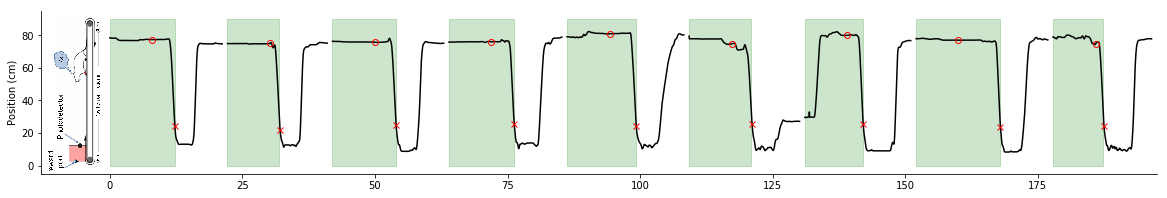

In [4]:
if "__file__" not in dir():
    path='/home/david/Pictures/TREADMILL.png'

    session='Rat123_2017_03_17_17_52'
    trials=[50,51,52,53,54,55,56,57,58]

    plt.close('all')
    ax=plt.figure(figsize=(20,3)).add_subplot(111);

    plot_consecutive_trajectories(root, session, trials, ax)
    add_treadmill_to_axis(ax,path,Xextention=12)

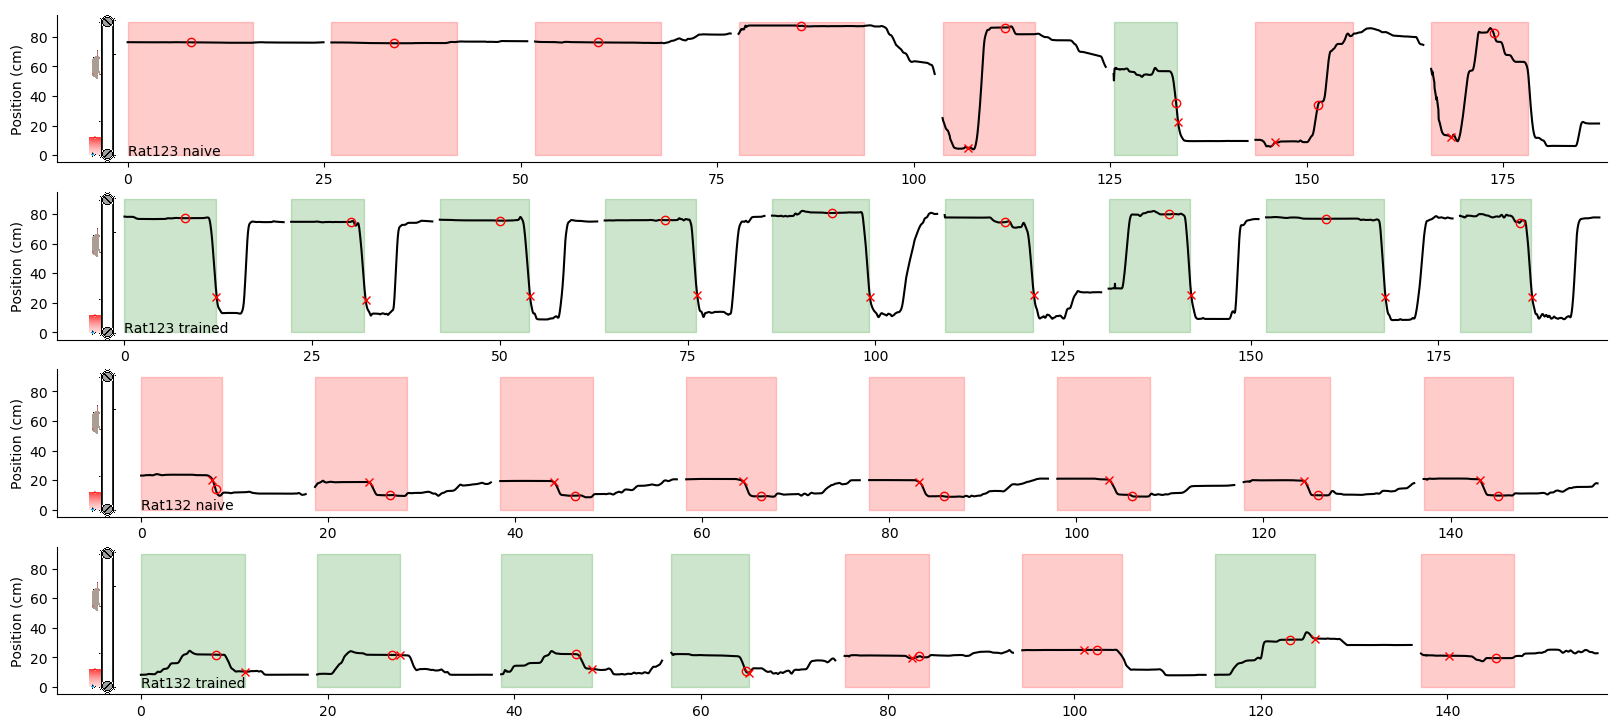

In [6]:
if "__file__" not in dir():
    path='/home/david/Pictures/TREADMILL2.png'
    fig=plt.figure(figsize=(20,9),dpi=100)
    naiveAx=fig.add_subplot(411)
    trainedAx=fig.add_subplot(412)
    NaiveStupidAx=fig.add_subplot(413)
    trainedStupidAx=fig.add_subplot(414)

    
    #plotting naive
    session='Rat123_2017_02_14_18_33'
    trials=range(10,18)
    plot_consecutive_trajectories(root, session, trials, naiveAx)
    add_treadmill_to_axis(naiveAx,path,Xextention=8)
    naiveAx.text(x=0, y=0, s=f'{session[:6]} naive')
    #plotting trained
    session='Rat123_2017_03_17_17_52'
    trials=range(50,59)
    plot_consecutive_trajectories(root, session, trials, trainedAx)
    add_treadmill_to_axis(trainedAx,path,Xextention=8)
    trainedAx.text(x=0, y=0, s=f'{session[:6]} trained')
    
    #plotting stupid naive animal
    session='Rat132_2017_05_26_13_34'
    trials=range(121,129)
    plot_consecutive_trajectories(root, session, trials, NaiveStupidAx)
    add_treadmill_to_axis(NaiveStupidAx,path,Xextention=8)
    NaiveStupidAx.text(x=0, y=0, s=f'{session[:6]} naive')

    #plotting stupid trained animal
    session='Rat132_2017_06_09_14_06'
    trials=range(70,78)
    plot_consecutive_trajectories(root, session, trials, trainedStupidAx)
    add_treadmill_to_axis(trainedStupidAx,path,Xextention=8)
    trainedStupidAx.text(x=0, y=0, s=f'{session[:6]} trained')
    
#     fig.savefig('/home/david/Pictures/tst.pdf',format='pdf')
    plt.show()
    plt.close('all')

plotting the trajectories of above example sessions

In [7]:
def position_aligned_on_entrance_time(root,session,Win):
    data=Data(root,session[:6],session,redoPreprocess=False)
    fs=data.cameraSamplingRate
    delay=data.cameraToTreadmillDelay
    posDict=data.position

    pos=[]
    trialColor=[]
    for trial in posDict:
        et=data.entranceTime[trial]
        position=posDict[trial]
        maxTrial=data.maxTrialDuration[trial]
        try:
            th=int((et+delay)*fs)
        except ValueError:
            logging.warning(f'session {session} trial {trial}: entrance time error')
            continue

        assert isinstance(th,int), 'blown up!'

        try:
            pos.append(posDict[trial][th-int(Win*fs):th+1])
        except IndexError:
            pos.append(posDict[trial][:th+1])

        if trial in data.goodTrials:
            trialColor.append('g') 
        else:
            trialColor.append('r')
        

    winL=stats.mode([len(i) for i in pos],nan_policy='omit')[0][0]
    position =np.ones((winL,len(pos))) * np.nan
    for i,traj in enumerate(pos):
        l=len(traj)
        position[winL-l:,i]=traj
    time=np.linspace(-Win,0,winL)
    return position, time, np.array(trialColor)

def plot_trajectories_aligned_on_entrance_time(root, ax, session, Win, treadmillRange):
    position,time,color=position_aligned_on_entrance_time(root,session, Win)

    lines=ax.plot(time,position,'k', lw=1)
    for i,line in enumerate(lines):
        line.set_color(color[i])
        line.set_zorder( color[i]=='g')

    histT0,bins0=np.histogram(position[0,:],30,range=(treadmillRange[0],treadmillRange[1]), density=True)
    ax.barh(bins0[:-1],-histT0*5,height=np.diff(bins0)[0],align='edge',left=-Win, color='k',zorder=0, alpha=.6)

    ax.set_xticks(np.arange(-Win,.1,.5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds(ax.get_xticks()[0],ax.get_xticks()[-1])
    ax.set_ylim(treadmillRange)
    ax.set_xlabel('Time to entrance time (s)')
    ax.set_ylabel('Position (cm)')

    return ax

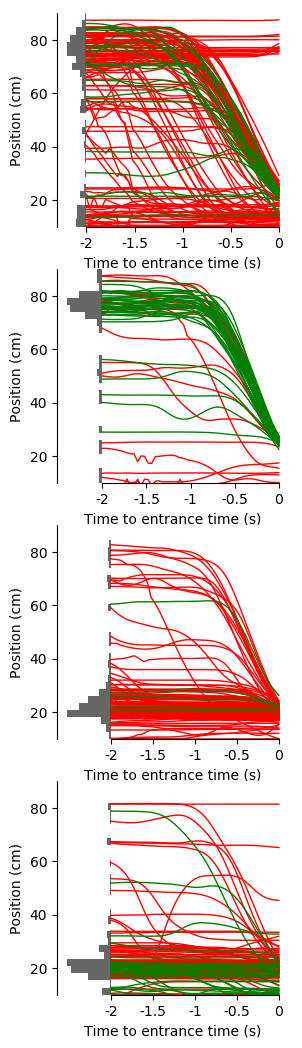

In [12]:
if "__file__" not in dir():
    #the inputs
    session='Rat123_2017_03_17_17_52'
    Win=2
    treadmillRange=[10,90]

    
    
    fig=plt.figure(figsize=(3,13),dpi=100)
    naiveAx=fig.add_subplot(411)
    trainedAx=fig.add_subplot(412)
    NaiveStupidAx=fig.add_subplot(413)
    trainedStupidAx=fig.add_subplot(414)

    
    #plotting naive
    session='Rat123_2017_02_14_18_33'
    plot_trajectories_aligned_on_entrance_time(root, naiveAx, session, Win, treadmillRange)
#     naiveAx.text(x=0, y=0, s=f'{session[:6]} naive')
    #plotting trained
    session='Rat123_2017_03_17_17_52'
    plot_trajectories_aligned_on_entrance_time(root, trainedAx, session, Win, treadmillRange)
#     trainedAx.text(x=0, y=0, s=f'{session[:6]} trained')
    
    #plotting stupid naive animal
    session='Rat132_2017_05_26_13_34'
    plot_trajectories_aligned_on_entrance_time(root, NaiveStupidAx, session, Win, treadmillRange)
#     NaiveStupidAx.text(x=0, y=0, s=f'{session[:6]} naive')

    #plotting stupid trained animal
    session='Rat132_2017_06_09_14_06'
    plot_trajectories_aligned_on_entrance_time(root, trainedStupidAx, session, Win, treadmillRange)
#     trainedStupidAx.text(x=0, y=0, s=f'{session[:6]} trained')
    
#     fig.savefig('/home/david/Pictures/tst.pdf',format='pdf')
    plt.show()
    plt.close('all')

Drawing the reward magnitude

In [13]:
def plot_reward_progression_schematic(ax, minReward, gt, maxTrial, maxReward, step, color,showYAxis):
    points=[(i,(i-minReward)/(gt-minReward)*.6) for i in np.arange(minReward,gt,step)]
    rewardRatio = lambda x: (-x/(maxReward-gt)+ (maxReward/(maxReward-gt)))

    for x,alpha in points:
        ax.plot( (x,gt), (0,1), alpha=alpha, color=color )

    ax.plot( (gt,gt), (1,0), alpha=1, color=color, lw=2 )
    ax.plot( (gt,maxTrial), (1,rewardRatio(maxTrial)), alpha=1, color=color, lw=2 )
    ax.plot( (maxTrial,maxReward), (rewardRatio(maxTrial),0), ':', alpha=1, color=color, lw=2)

    ax.yaxis.set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([minReward, gt, maxTrial, maxReward])
    ax.tick_params(top='off', bottom='off', left='off', right='off', labelleft='on', labelbottom='on')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.set_xlim([minReward,maxReward])
    if showYAxis:
        ax.yaxis.set_visible(True)
        ax.spines['left'].set_visible(True)
        ax.set_ylim([0,1])
        ax.set_yticks([0,1])
        ax.set_yticklabels(['zero', 'max'])

    #adding the text
    ax.set_title('Reward\nMagnitude')
    ax.set_xlabel('Entrance Time (s)')
    
    return ax

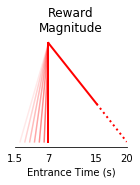

In [14]:
if "__file__" not in dir():
    minReward=1.5
    gt=7
    maxTrial=15
    maxReward=20
    step=.8
    color='r'
    showYAxis=False
    ax=plt.figure(figsize=(2,2)).add_subplot(111);

    plot_reward_progression_schematic(ax, minReward, gt, maxTrial, maxReward, step, color,showYAxis)
    
    plt.show()
    plt.close('all')

group ET learning curve

In [15]:
def plot_dotted_learning_curve(ax, root, animalList, profile, TaskParamToPlot, stop_dayPlot, seed=1):
    Results,_=get_rat_group_statistic(root,
                                      animalList,
                                      profile,
                                      parameter=param,
                                      redo=False,
                                      stop_dayPlot=stop_dayPlot,
                                      TaskParamToPlot=[TaskParamToPlot])

    goalTime=data_fetch(root, animal=animalList[0], profile=profile,
                        PerfParam= [lambda data:data.goalTime[-1]],
                        NbSession=0).values()
    goalTime=list(goalTime)[-1]
    
    x=np.arange(stop_dayPlot)+1
    data=np.array( list( Results[TaskParamToPlot].values() ) )
    y=np.nanpercentile(data,50,axis=0)
    yerr=np.nanpercentile(data,(25,75),axis=0)
    np.random.seed(seed=seed)
    sigma=.1
    
    ax.errorbar(x,y,yerr=abs(yerr-y), ecolor='k', fmt='k-o', markerfacecolor='w',zorder=1)
    for pts,day in zip(data.T,x):
        jitter=np.random.normal(day, sigma, len(pts))
        jitter=np.clip(a=jitter, a_min=day-2*sigma, a_max=day+2*sigma)
        ax.scatter(jitter,pts,s=10,c=range(len(animalList)),cmap='plasma', marker='o',zorder=2)

    ax.set_xlim([x[0]-1,x[-1]+1])
    ax.set_xticks(range(1,stop_dayPlot+1))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
#     ax.grid(b=True, which='major', axis='x')
    ax.hlines(y=goalTime, xmin=x[0], xmax=x[-1], linestyle='--')
    ax.text(x=x[5], y=goalTime[-1], s='goal time', verticalalignment='center', backgroundcolor='w')
#     ax.spines['left'].set_position(('data',-1))

    ax.set_xlabel('Session')
    ax.set_ylabel(TaskParamToPlot)
    
    return ax

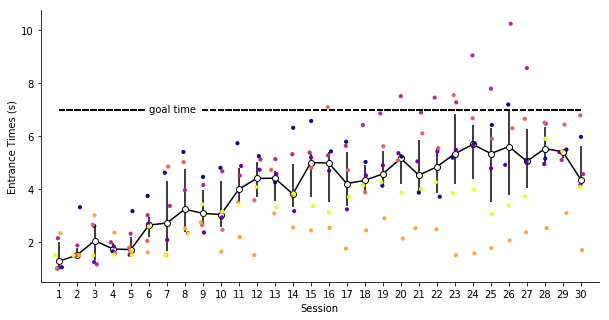

In [16]:
if "__file__" not in dir():

    profile={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':'0',
             'Speed':'0',
             'Tag':['ImmobileTreadmill']
             }
    animalList=batch_get_animal_list(root,profile)
    animalList=['Rat121','Rat122','Rat123','Rat124','Rat131','Rat132']

    TaskParamToPlot="percentile entrance time"
    stop_dayPlot =30
    
    plt.close('all')
    fig=plt.figure(figsize=(10,5))
    ax=fig.add_subplot(111);
    
    plot_dotted_learning_curve(ax, root, animalList, profile, TaskParamToPlot, stop_dayPlot)
    ax.set_ylabel('Entrance Times (s)')